# Spin Configuration Generator

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

### Loading Datasets

You can load different datasets by changing the dataset path for testing, trainging, and benchmarking

In [2]:
L = 32

In [3]:
# Set these variables to the appropriate directory paths

train_dir = '../data/{}-{}/temp_class/train/'.format(L,L)

# Set these variables to the appropriate directory paths
benchmark_dir = '../data/{}-{}/temp_class/test/'.format(L,L)

In [4]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

#create datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=dset_transform)
# test_data = datasets.ImageFolder(test_dir, transform=dset_transform)
benchmark_data = datasets.ImageFolder(benchmark_dir, transform=dset_transform)

batch_size = 64
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
num_classes = len(train_data.classes)
print(num_classes)

27


### Helper functions

Thanks to Teal Witter for code for these helper functions https://github.com/rtealwitter/dl-demos/blob/b537a5dd94953ea656a2140227af78f67c042540/demo11-conditional-gan.ipynb

In [6]:
def normalize_generator_output(x):
    #convert to binary data
    x[x>=0.5] = 1
    x[x<0.5] = 0
    return x

In [7]:
def to_onehot(x, num_classes=2):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c


In [8]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([L*num_classes, L*num_classes])
    for j in range(num_classes):
        c = torch.zeros([num_classes, num_classes]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(num_classes, n_noise).to(DEVICE)
        y_hat = G(z,c).view(num_classes, L, L)
        y_hat = normalize_generator_output(y_hat)
        result = y_hat.cpu().data.numpy()
        img[j*L:(j+1)*L] = np.concatenate([x for x in result], axis=-1)
    return img

In [9]:
input_size = [L,L]
hidden_layers = 10
layer_size = 256

## Architecture

Define the architecture of the generator and discriminator

In [10]:
def linear_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Linear(layer_size, layer_size))
        layers.append(nn.LeakyReLU())
    return layers

In [11]:
class Generator(nn.Module):
    def __init__(self, image_dim, hidden_layers, layer_size, num_classes, input_size=100):
        super(Generator, self).__init__()
        self.image_size = np.prod(image_dim)
        self.input_layer = [nn.Linear(input_size + num_classes, layer_size)]
        self.hidden_layers = linear_block(layer_size, hidden_layers)
        self.output_layer = [nn.Linear(layer_size, self.image_size), nn.Tanh()]
        self.model = nn.Sequential(*self.input_layer, *self.hidden_layers, *self.output_layer)

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat([x, c], dim=1)
        return self.model(v)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, hidden_layers, layer_size, num_classes):
        super(Discriminator, self).__init__()
        self.image_size = np.prod(image_dim)
        self.input_layer = [nn.Linear(self.image_size + num_classes, layer_size)]
        self.hidden_layers = linear_block(layer_size, hidden_layers)
        self.output_layer = [nn.Linear(layer_size, 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.input_layer, *self.hidden_layers, *self.output_layer)

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat([x, c], dim=1)
        return self.model(v)

## Setup and Training

In [13]:
MODEL_PATH = './models/{}-{}-GAN/'.format(L,L)
SAMPLE_PATH = '../generated_samples/{}-{}-GAN/'.format(L,L)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator(input_size, hidden_layers, layer_size, num_classes).to(DEVICE)
G = Generator(input_size, hidden_layers, layer_size, num_classes).to(DEVICE)

max_epoch = 25
step = 0
n_noise = 100 # noise dimension

criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [14]:
if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(train_loader):
        # Train Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        y = to_onehot(y, num_classes=num_classes).to(DEVICE)

        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        G_loss = -1 * criterion(z_outputs, D_fakes)

        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if step % 100 == 0:
            print('Epoch: {}, Step: {}, D_loss: {}, G_loss: {}'.format(epoch, step, D_loss.item(), G_loss.item()))
            
        if step % 500 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            plt.imsave(SAMPLE_PATH + 'sample-{}-{}.png'.format(epoch, step), img, cmap='gray')
            G.train()

        step += 1


Epoch: 0, Step: 0, D_loss: 1.386340618133545, G_loss: -0.6905670166015625
Epoch: 0, Step: 100, D_loss: 1.4240598678588867, G_loss: -0.5234434604644775
Epoch: 1, Step: 200, D_loss: 1.2820494174957275, G_loss: -0.6754125952720642
Epoch: 2, Step: 300, D_loss: 1.3635327816009521, G_loss: -0.3854663372039795
Epoch: 3, Step: 400, D_loss: 1.4038431644439697, G_loss: -0.5754072666168213
Epoch: 4, Step: 500, D_loss: 1.417609691619873, G_loss: -0.8405766487121582
Epoch: 5, Step: 600, D_loss: 1.3810269832611084, G_loss: -0.7694504261016846
Epoch: 6, Step: 700, D_loss: 1.266980528831482, G_loss: -0.6076144576072693
Epoch: 7, Step: 800, D_loss: 1.1777050495147705, G_loss: -0.5697596073150635
Epoch: 7, Step: 900, D_loss: 1.6167556047439575, G_loss: -0.7915401458740234
Epoch: 8, Step: 1000, D_loss: 1.384061574935913, G_loss: -0.6567367315292358
Epoch: 9, Step: 1100, D_loss: 1.376344084739685, G_loss: -0.6526846885681152
Epoch: 10, Step: 1200, D_loss: 1.4080255031585693, G_loss: -0.6743350625038147
Ep

### Displaying the generated images

In [15]:
def generate_image(G, device, n_noise, label):
    G.eval()
    c = torch.zeros([1, num_classes]).to(device)
    c[:, label] = 1
    z = torch.randn(1, n_noise).to(device)
    y_hat = G(z,c).view(1, L, L)
    y_hat = normalize_generator_output(y_hat)
    # print(y_hat)
    result = y_hat.cpu().data.numpy()
    G.train()
    return result[0]


1.0


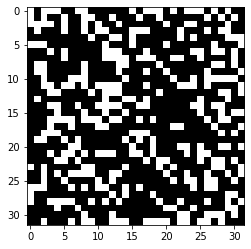

In [46]:
label = 0
temp = train_data.classes[label]
print(temp)
img = generate_image(G, DEVICE, n_noise, 0)
# print(img.shape)
# print(img)
plt.imshow(img, cmap='gray')

In [49]:
img = img.astype(np.uint8) * 255
image = Image.fromarray(img, 'L')
image.save('../generated_samples/test.png', 'PNG')


3.4000000000000004


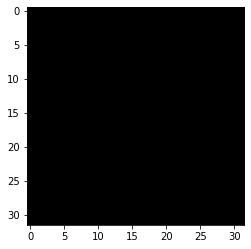

In [40]:

label = 25
temp = train_data.classes[label]
print(temp)
img = generate_image(G, DEVICE, n_noise, 15)
plt.imshow(img, cmap='gray')

In [30]:
image = Image.fromarray(img, 'L')
image.save('../generated_samples/test.png', 'PNG')

In [26]:
# save model
torch.save(G, MODEL_PATH+'G.pth')

## Analyzing the Output of the Generator.

We want to see if the generator can generate realisitic images. We can use our dataset to compare its output with the simulation model.

First, let us generate a graph of magnetization vs temperature for our existing dataset

In [19]:
def get_magnetization(img):
    img = img.numpy()
    img = img - 0.5
    mag = np.sum(img)
    return mag


In [20]:
#import the dataset
data_dir = '../data/{}-{}/temp_class/test'.format(L,L)

test_data = datasets.ImageFolder(data_dir, transform=dset_transform)

[['0.5', 131192.82], ['0.5', 262264.82], ['0.5', 393336.82], ['0.5', 524408.8200000001], ['0.5', 655480.8200000001], ['0.5', 786552.8200000001], ['0.5', 917624.8200000001], ['0.5', 1048696.82], ['0.5', 1179768.82], ['0.5', 1310840.82], ['0.5', 1441912.82], ['0.5', 1572984.82], ['0.5', 1704056.82], ['0.5', 1835128.82], ['0.5', 1966200.82], ['0.5', 2097272.8200000003], ['0.5', 2228344.8200000003], ['0.5', 2359416.8200000003], ['0.5', 2490488.8200000003], ['0.5', 2621560.8200000003], ['0.5', 2752632.8200000003], ['0.5', 2883704.8200000003], ['0.5', 3014776.8200000003], ['0.5', 3145848.8200000003], ['0.5', 3276920.8200000003], ['0.5', 3407992.8200000003], ['0.5', 3539064.8200000003], ['0.5', 3670136.8200000003], ['0.5', 3801208.8200000003], ['0.5', 3932280.8200000003], ['0.5', 4063352.8200000003], ['0.5', 4194424.82], ['0.5', 4325496.82], ['0.5', 4456568.82], ['0.5', 4587640.82], ['0.5', 4718712.82], ['0.5', 4849784.82], ['0.5', 4980856.82], ['0.5', 5111928.82], ['0.5', 5243000.82], ['0.5'

TypeError: list indices must be integers or slices, not tuple

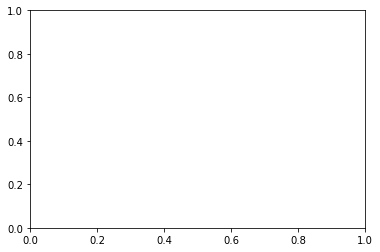

In [21]:
#loop through the dataset and get the average magnetization at each temperature
magnetizations = []

for i in range(len(test_data)):
    images, label = test_data[i]
    m = np.empty([len(images)])
    #get the magnetization of each image
    for j in range(len(images)):
        img = images[j]
        mag = get_magnetization(img)
        mag = np.square(mag)
        m = np.append(m, mag)

    #get the average magnetization of the images
    avg_mag = np.mean(m)

    #get the temp from the label
    temp = test_data.classes[label]
    magnetizations.append([temp, avg_mag])

print(magnetizations)

#plot the magnetization by temperature
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(magnetizations[:,0], magnetizations[:,1])

plt.show()